In [1]:
import tqdm
from sklearn.cluster import KMeans

from embeddings.embedding_utils import to_full_name
from embeddings.embedding_utils import get_queries
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from embeddings.embedding_utils import simple_clean_list
from data.arxiv_abstracts_2021 import load_with_querry_inner_folder
from data.Categorizer import Categorizer
from pyclustering.cluster.xmeans import xmeans
from umap import UMAP

figure_path = "figures_keyword_clustering_derivation"

In [2]:
data_querries = get_queries()
category =list(data_querries.keys())[0]
query = data_querries[category][1]
print(f"{category}: {query}")

Computer Science and AI: Federated learning


In [3]:
categorizer = Categorizer()
corpus, numerical_labels = load_with_querry_inner_folder(categorizer, query, limit=None)
print(f"no of retrieved Documents: {len(corpus)}")

no of retrieved Documents: 1615


In [4]:
cleaned_corpus = simple_clean_list(corpus)

# sammele Document frequency
word_freq = {}
for document in cleaned_corpus:
    for word in set(document):
        word_freq[word] = word_freq.get(word, 0) + 1

sorted_words_by_freq = sorted(word_freq.items(), key=lambda x: x[1])
print(f"Unique Words: {len(word_freq)}")

100%|██████████| 1615/1615 [00:00<00:00, 5649.00it/s]


Unique Words: 9800


## Select Keyword Cutoff based on frequency

In [5]:
cutoff_frequencies = [5,15,30,60,100,np.inf]
buckets = [set() for _ in range(len(cutoff_frequencies))]
current_cutoff_index = 0

for word,freq in sorted_words_by_freq:
    for i, cutoff in enumerate(cutoff_frequencies):
        if cutoff < freq:
            continue
        else:
            buckets[i].add((word,freq))
            break
for bucket in buckets:
    if len(bucket)==0:
        bucket.add(("__sential__",0))

In [6]:
backslash_str = r" \\ "
table = f"""\makecell{{Word \\\\ Frequency}}&
\makecell{{1-{cutoff_frequencies[0]}}}  & \makecell{{-{cutoff_frequencies[1]}}} & \makecell{{-{cutoff_frequencies[2]}}} & \makecell{{-{cutoff_frequencies[3]}}} & \makecell{{-{cutoff_frequencies[4]}}} & \makecell{{\\textgreater{cutoff_frequencies[4]}}}  \\\\
\midrule
\makecell{{Sample \\\\ Words}} &
\makecell{{{ backslash_str.join(np.random.choice([word for word,_ in buckets[0]],5)) }}} &
\makecell{{{ backslash_str.join(np.random.choice([word for word,_ in buckets[1]],5)) }}} &
\makecell{{{ backslash_str.join(np.random.choice([word for word,_ in buckets[2]],5)) }}} &
\makecell{{{ backslash_str.join(np.random.choice([word for word,_ in buckets[3]],5)) }}} &
\makecell{{{ backslash_str.join(np.random.choice([word for word,_ in buckets[4]],5)) }}} &
\makecell{{{ backslash_str.join(np.random.choice([word for word,_ in buckets[5]],5)) }}} \\\\
\midrule
\makecell{{Unique \\\\ Words}} &
\makecell{{{len(buckets[0])}}}  & \makecell{{{len(buckets[1])}}} & \makecell{{{len(buckets[2])}}} & \makecell{{{len(buckets[3])}}} & \makecell{{{len(buckets[4])}}} & \makecell{{{len(buckets[5])}}}  \\\\"""
print (table)

\makecell{Word \\ Frequency}&
\makecell{1-5}  & \makecell{-15} & \makecell{-30} & \makecell{-60} & \makecell{-100} & \makecell{\textgreater100}  \\
\midrule
\makecell{Sample \\ Words} &
\makecell{heterogeneously \\ middleware \\ cancellation \\ leader \\ distributedml} &
\makecell{centralised \\ sourced \\ serve \\ w \\ relatively} &
\makecell{drop \\ progress \\ investigates \\ matrix \\ consistently} &
\makecell{properties \\ leverages \\ uploading \\ typically \\ protecting} &
\makecell{collected \\ out \\ developed \\ attention \\ costs} &
\makecell{framework \\ scale \\ number \\ prediction \\ evaluate} \\
\midrule
\makecell{Unique \\ Words} &
\makecell{6695}  & \makecell{1460} & \makecell{639} & \makecell{446} & \makecell{222} & \makecell{338}  \\


So we cut the top n percent

In [7]:
bound = int(0.9*len(sorted_words_by_freq))
selected_keywords = {word for word, _ in sorted_words_by_freq[:bound]}

In [8]:
# count ratio of selected/unselected words.
selected_count = 0
unselected_count = 0
for document in cleaned_corpus:
    for word in document:
        if word in selected_keywords:
            selected_count += 1
        else:
            unselected_count +=1

print(f"Selected: {selected_count}\nUnselected: {unselected_count}\n Ratio selected: {selected_count / (selected_count + unselected_count)}")

Selected: 52471
Unselected: 264985
 Ratio selected: 0.16528589788821127


In [9]:
# load the static word translator
filename = "../data/vector_translator/translator.pickle"
with open(filename, "rb") as f:
    translator = pickle.load(f)

In [10]:
print("Creating keyword embeddings...")
keyword_list = list(set(translator.keys()).intersection(selected_keywords))
keyword_embeddings = np.array([translator[keyword] for keyword in keyword_list])
print("Keyword embeddings created.")
print("Getting 2D embedding via UMAP")
keyword_embeddings_2d = UMAP(n_components=2).fit_transform(keyword_embeddings)
keyword_embeddings_3d = UMAP(n_components=3).fit_transform(keyword_embeddings)
print("2D embeddings reduced.")

Creating keyword embeddings...
Keyword embeddings created.
Getting 2D embedding via UMAP


C:\bachelor\article-clustering\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\bachelor\article-clustering\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


2D embeddings reduced.


In [11]:
def get_closest_words(cluster_centers):
    representatives = ["not found yet"]* len(cluster_centers)
    for i, center in enumerate(cluster_centers):
        min_dist = float("inf")
        for keyword in keyword_clusters[i]:
            dist = np.linalg.norm(center-translator[keyword])
            if dist < min_dist:
                min_dist = dist
                representatives[i] = keyword
    return representatives

In [50]:
def normal_xmeans(data_matrix):
    k_start = 10
    if data_matrix.shape[0] < k_start:
        return np.zeros(data_matrix.shape[0]), np.mean(data_matrix)
    initial_centers = data_matrix[np.random.choice(data_matrix.shape[0], k_start, replace=False)]
    xmeans_instance = xmeans(data_matrix, initial_centers, kmax=30)
    xmeans_instance.process()

    labels = np.zeros(len(data_matrix), dtype=int)  # Assign cluster labels
    for cluster_idx, cluster in enumerate(xmeans_instance.get_clusters()):
        for idx in cluster:
            labels[idx] = cluster_idx

    centroids = xmeans_instance.get_centers()
    return np.array(labels), np.array(centroids)

In [13]:
def fixed_kmeans(data_matrix, k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit_transform(data_matrix)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    return np.array(labels), np.array(centroids)

In [53]:
keyword_labels, keyword_centroids = normal_xmeans(keyword_embeddings)
unique_labels = set(keyword_labels)
print(f"Found {len(unique_labels)} clusters")
keyword_clusters = {}
for label, keyword in zip(keyword_labels, keyword_list):
    if label not in keyword_clusters:
        keyword_clusters[label] = []
    keyword_clusters[label].append(keyword)
unique_labels = set(keyword_labels)
cluster_representatives = get_closest_words(keyword_centroids)

Found 15 clusters


In [54]:
def get_mask(x):
    border = 0.02
    abs_border = (max(x)-min(x))*border
    return np.logical_and(x>min(x)+abs_border, x<max(x)-abs_border)
def cut_vis_2(x,y):
    mask_x = get_mask(x)
    mask_y = get_mask(y)
    return x[np.logical_and(mask_x,mask_y)], y[np.logical_and(mask_x,mask_y)]

def cut_vis(x,y,z):
    mask_x = get_mask(x)
    mask_y = get_mask(y)
    mask_z = get_mask(z)
    total_mask = np.logical_and(mask_x, mask_y,mask_z)
    return x[total_mask], y[total_mask], z[total_mask]


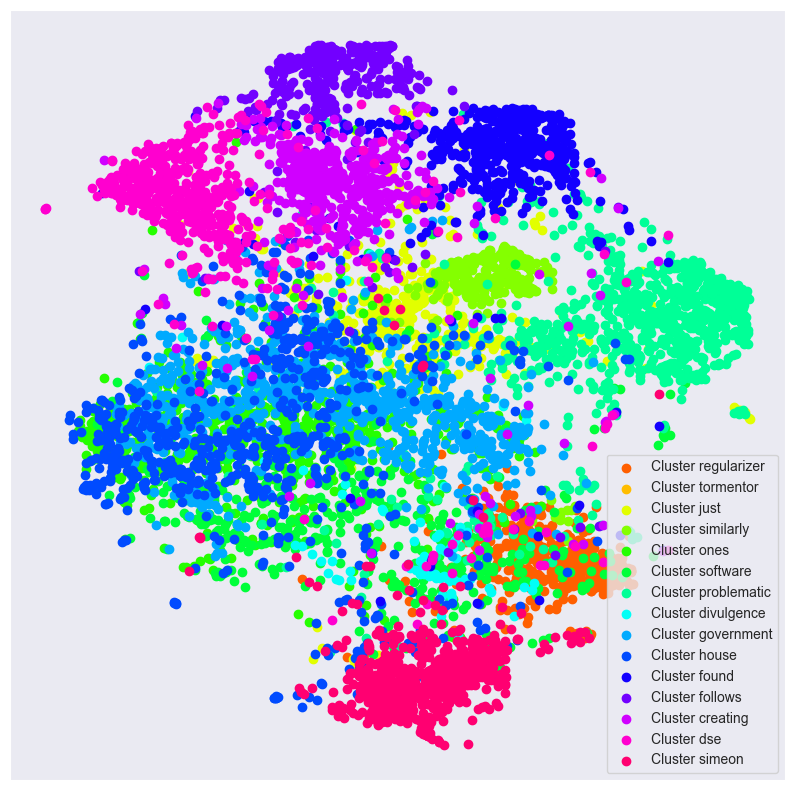

In [55]:
# vizualize current clusters
plt.figure(figsize=(10,10))
colors = sns.color_palette("hsv", len(unique_labels))
for label in unique_labels:
    mask = keyword_labels == label
    x,y = cut_vis_2(keyword_embeddings_2d[mask, 0], keyword_embeddings_2d[mask, 1])
    plt.scatter(x,y, color=colors[label], label=f"Cluster {cluster_representatives[label]}")
plt.xticks([])
plt.yticks([])



plt.legend()
# plt.savefig(f"{figure_path}/keyword_clustering_xmeans_2d.png", dpi=300, bbox_inches='tight')
plt.show()


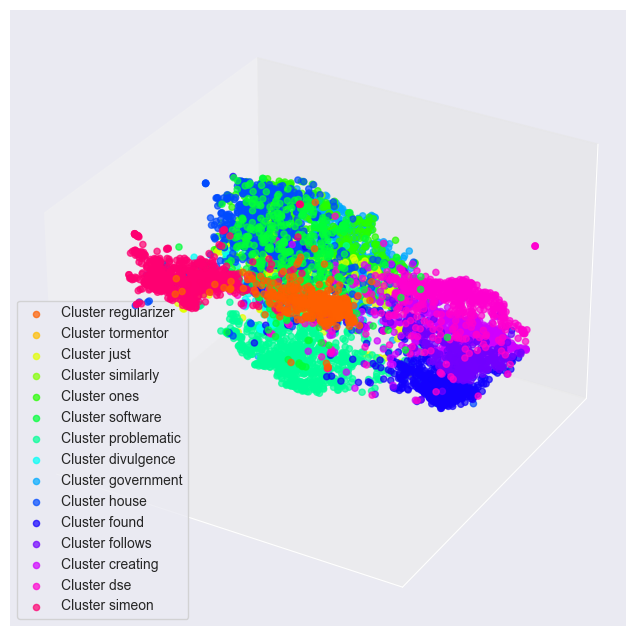

In [56]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

colors = sns.color_palette("hsv", len(unique_labels))

for label in unique_labels:
    mask = keyword_labels == label
    x,y,z = cut_vis(
        keyword_embeddings_3d[mask, 0],
        keyword_embeddings_3d[mask, 1],
        keyword_embeddings_3d[mask, 2])
    ax.scatter(x,y,z,
        color=colors[label],
        label=f"Cluster {cluster_representatives[label]}",
        alpha=0.7,
    )

# Remove tick marks from all axes
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.legend()
# plt.savefig(f"{figure_path}/keyword_clustering_xmeans_3d.png", dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# example table of words in clusters
n_samples = 20
random_sample_words = [np.random.choice(keyword_clusters[label], n_samples, replace=True) for label in range(len(unique_labels))]
random_sample_words = np.array(random_sample_words).T
sample_words_df = pd.DataFrame(random_sample_words, columns=cluster_representatives)
print(sample_words_df)


     simeon           just           ofl         dse  problematic  \
0   newdata        perhaps     explosion   revisited    redundant   
1   spanish        another           cap    conclude   profitable   
2       rdp         longer     dimension      return    falsified   
3       uav     ostensibly  intermediary  discarding     impaired   
4      safa  comparatively         blood      dubbed        newer   
5       afd           tens         virus   refreshed       prompt   
6   neumann            his   speculation     hurting    divergent   
7       vlc        outside           lfw      builds     abnormal   
8        kf     externally         query    revisits    identical   
9      rffl    drastically           hop     manages      desired   
10      sri       assuming       ringfed   forwarded      apropos   
11  neumann     throughout          clip    organize     stealthy   
12  tinyurl         whilst       billing   organizes    incorrect   
13  senario          ahead        

In [19]:
# Lets see document closeness to a specific cluster
selected_cluster_name = "procesing"
selected_cluster_index = cluster_representatives.index(selected_cluster_name)
selected_cluster_centroid = keyword_centroids[selected_cluster_index]

# sample_indices = np.random.choice(len(cleaned_corpus), 7, replace=False)
sample_indices = np.array([57,149,566,560,1193,1149,942])

In [20]:
document_samples = [cleaned_corpus[i] for i in sample_indices]
original_documents = corpus.iloc[sample_indices]

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

closenesses = []
for document_sample in document_samples:
    doc_closenesses = []
    for word in document_sample:
        if word in translator:
            doc_closenesses.append(cosine_similarity(translator[word].reshape(1,-1), selected_cluster_centroid.reshape(1,-1))[0][0])
    closenesses.append(doc_closenesses)

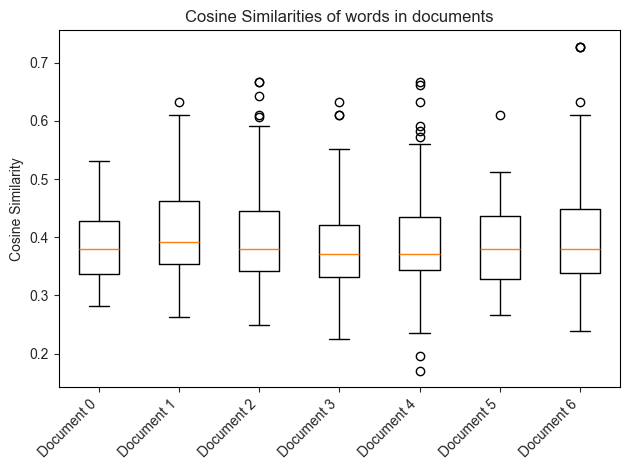

In [22]:
# create 5 boxplots side-by-side of the closenesses distributions
fig, ax = plt.subplots()

# Create side-by-side boxplots for the data
ax.boxplot(closenesses)
ax.grid(False)
ax.set_facecolor('white')

# Ensure all spines (outline of the axes) are visible
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor('black')

# Ensure ticks are visible
ax.tick_params(axis='both', which='both', bottom=True, left=True)
# Label each boxplot with custom names on the x-axis
ax.set_xticklabels([f"Document {i}" for i in range(len(closenesses))])
plt.xticks(rotation=45, ha="right", fontsize=10)

# Add labels and title
ax.set_ylabel('Cosine Similarity')
ax.set_title('Cosine Similarities of words in documents')


# save and display
plt.tight_layout()
# plt.savefig(f'{figure_path}/boxplot_similarity_distances_n_documents_to_{selected_cluster_name}.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
cosine_cache = {}

def cosine_cached(key, cluster_center, word_embedding):
    if key in cosine_cache:
        return cosine_cache[key]
    sim = cosine_similarity(cluster_center.reshape(1,-1), word_embedding.reshape(1, -1))
    cosine_cache[key] = sim
    return sim

In [24]:
# idea: select average of the top 5% on similarities.
document_embeddings = []
for document in cleaned_corpus:
    # calculate the similarity between every word and the keyword_cluster_centers
    embeddable_words = [word for word in document if word in translator]
    document_word_embeddings = np.array([translator[word] for word in document if word in translator])
    # remove the bias from the document embeddings

    # for every center, average of the top 10% are chosen as similarity
    keyword_cluster_coefficients = []
    for i, keyword_entroid in enumerate(keyword_centroids):
        similarities = np.array([cosine_cached(str(i) +"_" + word, keyword_entroid, word_embedd) for word, word_embedd in zip(embeddable_words, document_word_embeddings)])

        cutoff = max(5, int(0.05 * len(similarities)))
        score = np.mean(np.sort(similarities)[-cutoff:])
        keyword_cluster_coefficients.append(score)

    document_embeddings.append(keyword_cluster_coefficients)

document_embeddings = np.array(document_embeddings)

# normalize with min-max scale each dimension to [-1,1]
mins = np.min(document_embeddings, axis=0)
maxs = np.max(document_embeddings, axis=0)
document_embeddings = 2*(document_embeddings-mins)/(maxs-mins)-1
document_embeddings = document_embeddings/np.linalg.norm(document_embeddings, axis=1, keepdims=True)

In [25]:
# show embedding with categories
document_embeddings_2d = UMAP(n_components=2).fit_transform(document_embeddings)
document_embeddings_3d = UMAP(n_components=3).fit_transform(document_embeddings)

C:\bachelor\article-clustering\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\bachelor\article-clustering\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [26]:
# get top 6 categories
category_frequency = {}
for category_list in numerical_labels:
    for category in category_list:
        category_frequency[category] = category_frequency.get(category, 0) + 1
sorted_categories = sorted(category_frequency.items(), key=lambda x: x[1], reverse=True)
top_n = 6
top_categories = [category for category, _ in sorted_categories[:top_n]]
top_category_names = [to_full_name(categorizer.get_label_str(category)) for category in top_categories]
top_category_masks = [np.array([top_category in category_list for category_list in numerical_labels]) for top_category in top_categories]

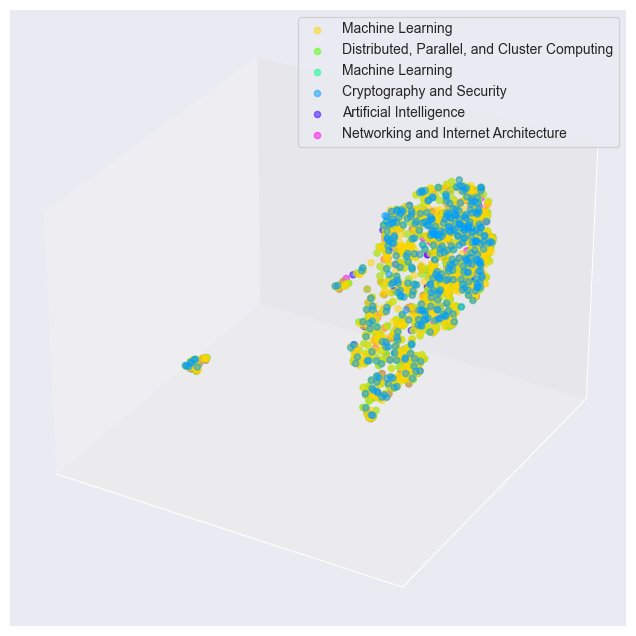

In [27]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

colors = sns.color_palette("hsv", top_n)

for i,(name, mask) in enumerate(zip(top_category_names, top_category_masks)):
    ax.scatter(
        document_embeddings_3d[mask, 0],
        document_embeddings_3d[mask, 1],
        document_embeddings_3d[mask, 2],
        color=colors[i],
        label=name,
        alpha=0.5
    )

# Remove tick marks from all axes
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.legend()
# plt.savefig(f"{figure_path}/document_embedding_with_original_categories_3d.png", dpi=300, bbox_inches='tight')
plt.show()

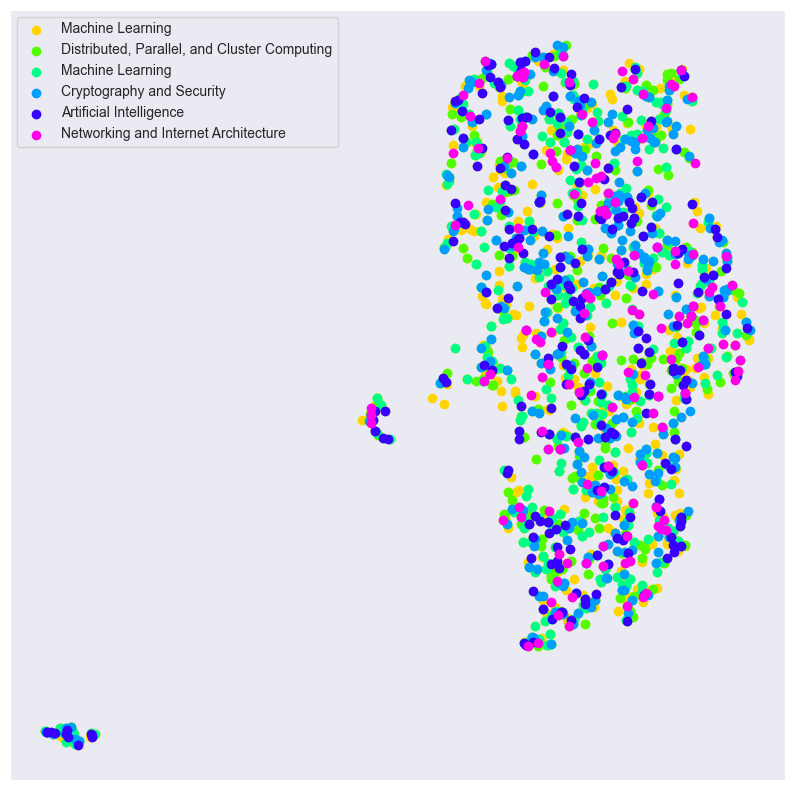

In [28]:
# 2d as well
plt.figure(figsize=(10,10))
colors = sns.color_palette("hsv", top_n)

plt.grid(False)

for i,(name, mask) in enumerate(zip(top_category_names, top_category_masks)):
    plt.scatter(
        document_embeddings_2d[mask, 0],
        document_embeddings_2d[mask, 1],
        color=colors[i],
        label=name
    )

# Remove tick marks from all axes
plt.xticks([])
plt.yticks([])

plt.legend()
# plt.savefig(f"{figure_path}/document_embedding_with_original_categories_2d.png", dpi=300, bbox_inches='tight')
plt.show()

In [29]:
#new approach:
# 1. set get lots of clusters
# 2. filter on intra-document variability

In [30]:
keyword_labels, keyword_centroids = fixed_kmeans(keyword_embeddings, 500)
unique_labels = set(keyword_labels)
print(f"Found {len(unique_labels)} clusters")
keyword_clusters = {}
for label, keyword in zip(keyword_labels, keyword_list):
    if label not in keyword_clusters:
        keyword_clusters[label] = []
    keyword_clusters[label].append(keyword)
unique_labels = set(keyword_labels)
cluster_representatives = get_closest_words(keyword_centroids)

Found 500 clusters


In [31]:
from tqdm import tqdm
# get score for each
# idea: select average of the top 5% on similarities.
document_embeddings = []
for document in tqdm(cleaned_corpus):
    # calculate the similarity between every word and the keyword_cluster_centers
    embeddable_words = [word for word in document if word in translator]
    document_word_embeddings = np.array([translator[word] for word in document if word in translator])
    # remove the bias from the document embeddings

    # for every center, average of the top 10% are chosen as similarity
    keyword_cluster_coefficients = []
    for i, keyword_entroid in enumerate(keyword_centroids):
        similarities = np.array([cosine_cached(str(i) +"_" + word, keyword_entroid, word_embedd) for word, word_embedd in zip(embeddable_words, document_word_embeddings)])

        cutoff = max(5, int(0.05 * len(similarities)))
        score = np.mean(np.sort(similarities)[-cutoff:])
        keyword_cluster_coefficients.append(score)

    document_embeddings.append(keyword_cluster_coefficients)

document_embeddings = np.array(document_embeddings)


100%|██████████| 1615/1615 [49:44<00:00,  1.85s/it] 


In [32]:
varianves_per_coefficient = np.var(document_embeddings, axis=0)

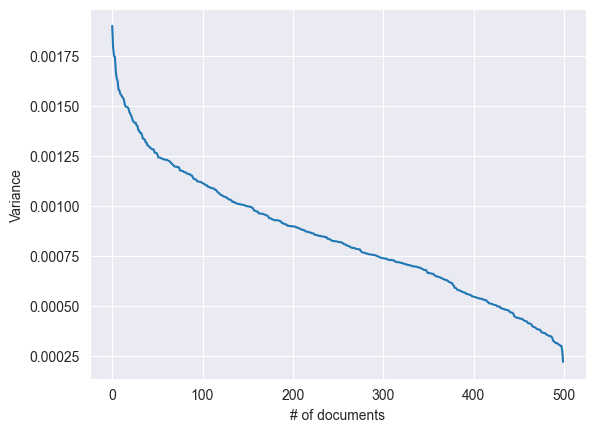

In [48]:
# plot all varances
sorted_variances = np.sort(varianves_per_coefficient)[::-1]
plt.plot(sorted_variances)

plt.ylabel('Variance')
plt.xlabel('# of documents')
plt.savefig(f"{figure_path}/coefficient_variability_500.png", dpi=300, bbox_inches='tight')
plt.show()

In [34]:
index_of_top_20_variances = np.argsort(varianves_per_coefficient)[-20:][::-1]
high_var_cluster_reps = np.array(get_closest_words(keyword_centroids))[index_of_top_20_variances]

In [35]:
# print lowest 5 cluster
index_of_low_5 = np.argsort(varianves_per_coefficient)[:5]
print(np.array(get_closest_words(keyword_centroids))[index_of_low_5])

['achilles' 'svm' 'p' 'hessians' 'offloading']


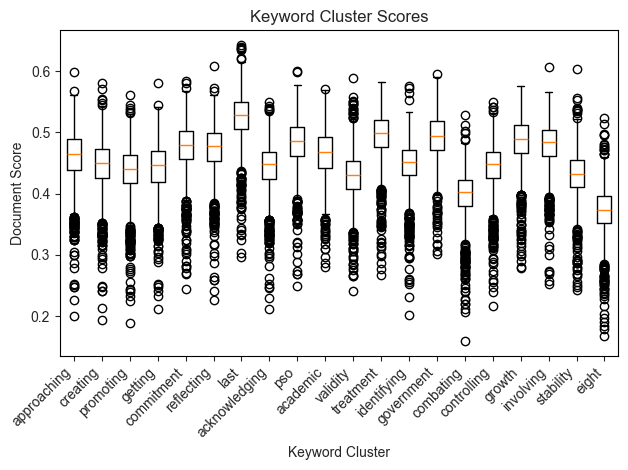

In [49]:
# boxplot of the top 20 variance coefficients
high_var_subset = document_embeddings[:,index_of_top_20_variances]

fig, ax = plt.subplots()

ax.boxplot(high_var_subset)
ax.grid(False)
ax.set_facecolor('white')

# Ensure all spines (outline of the axes) are visible
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor('black')
ax.tick_params(axis='both', which='both', bottom=True, left=True)



# Label each boxplot with custom names on the x-axis
ax.set_xticklabels(high_var_cluster_reps)
plt.xticks(rotation=45, ha="right", fontsize=10)

# Add labels and title
ax.set_ylabel('Document Score')
ax.set_title('Keyword Cluster Scores')
ax.set_xlabel('Keyword Cluster')


# save and display
plt.tight_layout()
plt.savefig(f'{figure_path}/boxplot_socre_of_top_20_variance_clusters_from_500.png', dpi=300, bbox_inches='tight')
plt.show()

In [37]:
# normalize
high_var_mins = np.min(high_var_subset, axis=0)
high_var_maxs = np.max(high_var_subset, axis=0)

high_var_subset_normalized = 2*(high_var_subset-high_var_mins)/(high_var_maxs-high_var_mins)-1

In [38]:
#normalize each document vector to length 1


high_var_subset_full_normalized= high_var_subset_normalized/np.linalg.norm(high_var_subset_normalized, axis=1, keepdims=True)

In [39]:
high_var_subset_reduced_3d = UMAP(n_components=3).fit_transform(high_var_subset_full_normalized)
high_var_subset_reduced_2d = UMAP(n_components=2).fit_transform(high_var_subset_full_normalized)

C:\bachelor\article-clustering\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\bachelor\article-clustering\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


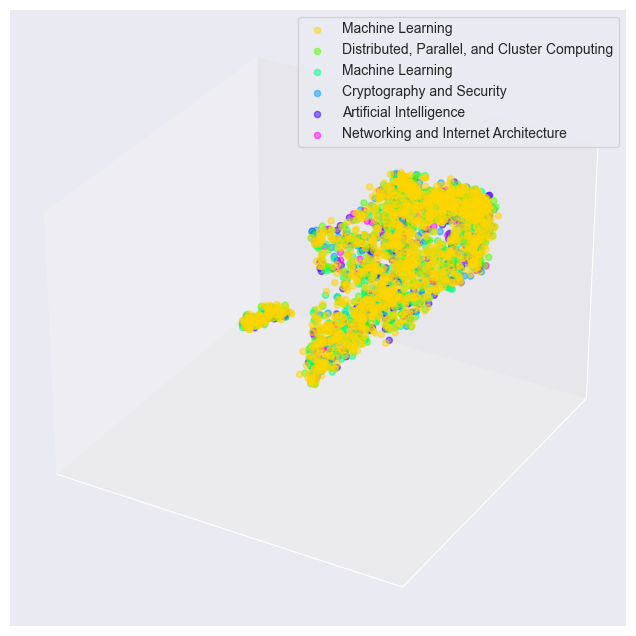

In [45]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

colors = sns.color_palette("hsv", top_n)

for i,(name, mask) in enumerate(zip(top_category_names, top_category_masks)):
    rand_factor = 0.3
    ax.scatter(
        high_var_subset_reduced_3d[mask, 0]+rand_factor*np.random.rand(*high_var_subset_reduced_2d[mask, 0].shape),
        high_var_subset_reduced_3d[mask, 1]+rand_factor*np.random.rand(*high_var_subset_reduced_2d[mask, 0].shape),
        high_var_subset_reduced_3d[mask, 2]+rand_factor*np.random.rand(*high_var_subset_reduced_2d[mask, 0].shape),
        color=colors[i],
        label=name,
        alpha=0.5
    )

# Remove tick marks from all axes
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.legend()
# plt.savefig(f"{figure_path}/high_var_document_embedding_with_original_categories_3d.png", dpi=300, bbox_inches='tight')
plt.show()

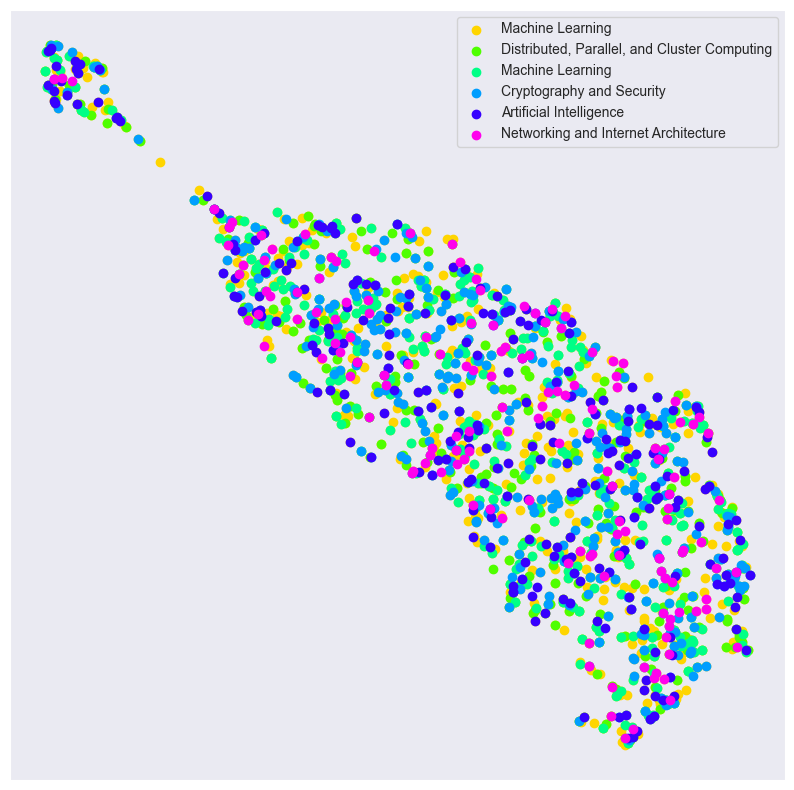

In [47]:
plt.figure(figsize=(10,10))
colors = sns.color_palette("hsv", top_n)

plt.grid(False)

for i,(name, mask) in enumerate(zip(top_category_names, top_category_masks)):
    rand_factor = 0
    plt.scatter(
        high_var_subset_reduced_2d[mask, 0]+rand_factor*np.random.rand(*high_var_subset_reduced_2d[mask, 0].shape),
        high_var_subset_reduced_2d[mask, 1]+rand_factor*np.random.rand(*high_var_subset_reduced_2d[mask, 1].shape),
        color=colors[i],
        label=name
    )

# Remove tick marks from all axes
plt.xticks([])
plt.yticks([])

plt.legend()
plt.savefig(f"{figure_path}/high_var_of_500_document_embedding_with_original_categories_2d.png", dpi=300, bbox_inches='tight')
plt.show()

## also shit lol